In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Callable
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from deep_hedging import (
    Underlyings,
    Ticker,
    ConstantRateCurve,
    EuropeanCall,
)
from deep_hedging.non_linear.base_option import BaseOption
from deep_hedging.monte_carlo import GBMSimulator

RANDOM_SEED = 12

In [3]:
N_PATHS = 10_000
N_STOCKS = 1
TILL_MATURITY = 3.0
N_DAYS = 365 * TILL_MATURITY
RF_RATE = 0.03
VOL = 0.2

In [4]:
N_DAYS

1095.0

In [5]:
np.random.seed(RANDOM_SEED)

start = dt.datetime(2019, 1, 1)
end = start + dt.timedelta(days=N_DAYS)

underlyings = Underlyings(
    tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
    start=start,
    end=end,
    dividends=np.array([0.0] * N_STOCKS),
    means=np.array([RF_RATE] * N_STOCKS),
    var_covar=np.array([VOL**2] * N_STOCKS),
)
underlyings.data

In [6]:
np.sqrt(np.diag(underlyings.get_var_covar()))

array([[0.2]])

In [7]:
curve = ConstantRateCurve(constant_rate=RF_RATE)

In [8]:
european_call = EuropeanCall(
    underlyings=underlyings,
    yield_curve=curve,
    strike_level=1.0,
    start_date=start,
    end_date=end,
)

In [9]:
pricer = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)

In [10]:
paths = pricer.get_paths(
    spot=[1.0],
    time_till_maturity=TILL_MATURITY,
    risk_free_rate_fn=curve.get_instant_fwd_rate,
    dividends_fn=lambda t: 0.0,
    var_covar_fn=lambda t: np.array([VOL**2] * len(t)),
    n_paths=N_PATHS,
).squeeze(2)
paths.shape

(10000, 757)

In [11]:
def get_greek(
    spot: np.array, till_maturity: np.array, greek_fn: Callable[[np.array], np.array]
) -> np.array:
    greek = []
    for day in range(spot.shape[1]):
        greek.append(
            list(
                greek_fn(spot=spot[:, day], till_maturity=till_maturity[day]).flatten()
            )
        )
    return np.array(greek).T

In [12]:
def get_pnl(spot: np.array, weights: np.array, dt: float) -> np.array:
    weights_all = np.concatenate(
        [
            np.zeros((spot.shape[0], 1)),
            weights,
            np.zeros((spot.shape[0], 1)),
        ],
        axis=1,
    )
    weights_diff = np.diff(weights_all, n=1, axis=1)
    # print(weights_diff.shape, spot.shape)

    # rates_diff = spot[:, :, 2] - spot[:, :, 3]
    rates_diff = RF_RATE

    bought = np.where(weights_diff > 0, weights_diff, 0)
    sold = np.where(weights_diff < 0, -weights_diff, 0)

    # cash_outflow = (-spot[:, 1:, 1] * bought).sum(axis=1)
    # cash_inflow = (-spot[:, 1:, 0] * sold).sum(axis=1)

    cash_outflow = -spot * bought
    cash_inflow = spot * sold

    cash_position = cash_outflow.cumsum(axis=1) + cash_inflow.cumsum(axis=1)

    interest = (rates_diff * dt * cash_position[:, :-1]).sum(axis=1)
    # interest = 0

    return cash_outflow.sum(axis=1) + cash_inflow.sum(axis=1) + interest

In [13]:
def simulate_pnl(spot: np.array, option: BaseOption) -> np.array:
    till_maturity = np.linspace(option.time_till_maturity, 1e-6, spot.shape[1])
    delta_paths = get_greek(spot, till_maturity, option.delta)
    # plt.plot(delta_paths[0])
    # plt.show()
    # print(delta_paths.min(), delta_paths.max())
    # print(delta_paths.mean(axis=1).mean(), (delta_paths.mean(axis=1) * 0.03 * 3.).mean())
    return (
        get_pnl(spot, delta_paths[:, :-1], 1 / 365),
        european_call.payoff(spot),
    )

In [14]:
pnl_hedge, pnl_opt = simulate_pnl(paths, european_call)
pnl_hedge.mean(), pnl_opt.mean()

(0.00016883375785257525, 0.19329709535494358)

In [15]:
pnl_opt.std(), pnl_hedge.std(), (pnl_hedge - pnl_opt).std()

(0.295840534441357, 0.29623850724938466, 0.004507093584090484)

In [16]:
np.corrcoef(pnl_hedge, pnl_opt)

array([[1.        , 0.99988501],
       [0.99988501, 1.        ]])

In [17]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).mean()

-0.0025549302853090177

In [18]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.295840534441357

In [19]:
(
    pnl_opt
    - pnl_hedge
    - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.004507093584090484

In [20]:
paths.shape

(10000, 757)

In [21]:
example_spot = np.array([100, 100, 150]).reshape(1, -1, 1)
example_weights = np.array([0.5, 1.0, 2.0]).reshape(1, -1)

In [22]:
example_pnl = get_pnl(example_spot, example_weights[:, :-1], 1.0)
example_pnl

array([[-179.5, -179.5,  359. ]])

In [23]:
example_spot.shape, example_weights.shape

((1, 3, 1), (1, 3))

In [24]:
pnl_hedge, pnl_opt = simulate_pnl(paths, european_call)
(pnl_opt - pnl_hedge).mean()

0.193128261597091

In [25]:
european_call.price()

array([[0.17899527]])

In [26]:
gammas = get_greek(
    paths,
    np.linspace(european_call.time_till_maturity, 1e-6, paths.shape[1]),
    european_call.gamma,
)
gammas.shape

(10000, 757)

In [27]:
paths_diff = np.diff(paths, n=1, axis=1)
gamma_pnl = (gammas[:, :-1] / 2 * paths_diff**2).sum(axis=1)
gamma_pnl.mean()

0.07522006963933286

In [28]:
pnl_hedge.mean()

0.00016883375785257525

In [29]:
(pnl_hedge + gamma_pnl).mean()

0.07538890339718544

In [30]:
pnl_opt.mean()

0.19329709535494358

In [31]:
(pnl_opt - pnl_hedge - gamma_pnl).mean()

0.11790819195775815

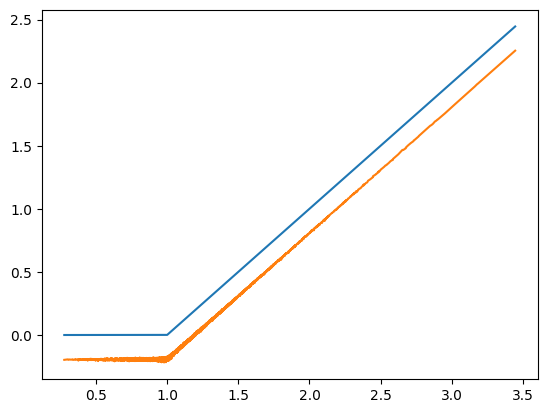

In [32]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

In [33]:
value_opt = european_call.price(spot=paths[:, -1])
value_opt.shape

(10000, 1)

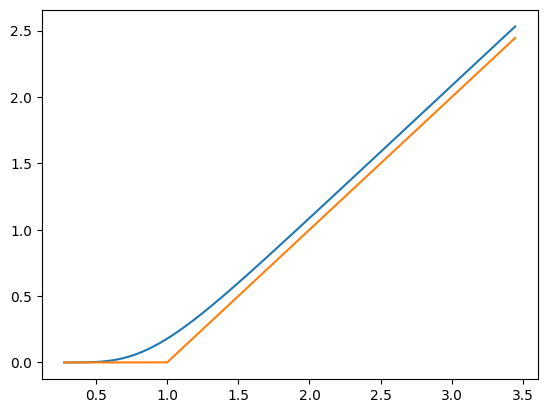

In [34]:
plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
# plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

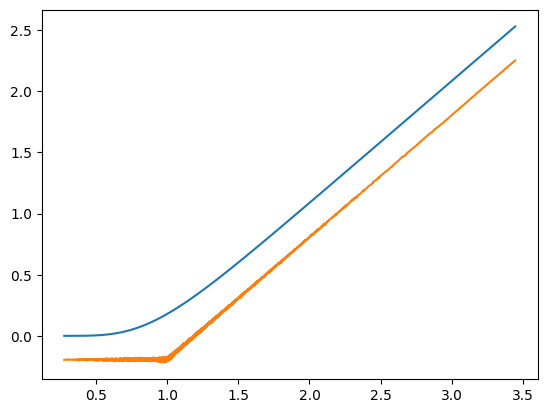

In [35]:
plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
# plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

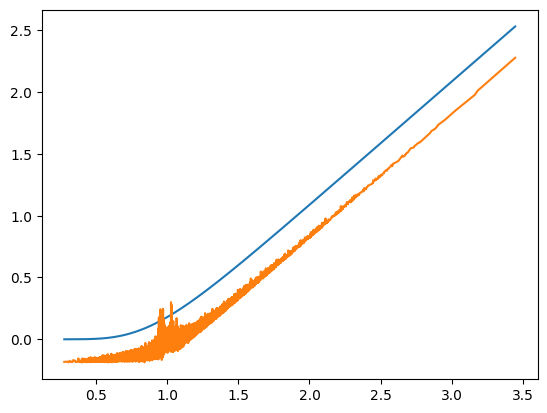

In [36]:
plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
# plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(
    np.sort(paths[:, -1]),
    pnl_hedge[np.argsort(paths[:, -1])] + gamma_pnl[np.argsort(paths[:, -1])],
)
plt.show()

In [37]:
np.sort(paths[:, -1])

array([0.27800143, 0.30263767, 0.30802662, ..., 3.17739453, 3.18157664,
       3.44471147])

In [38]:
pnl_opt[np.argsort(paths[:, -1])].shape

(10000,)

In [39]:
pnl_opt

array([0., 0., 0., ..., 0., 0., 0.])

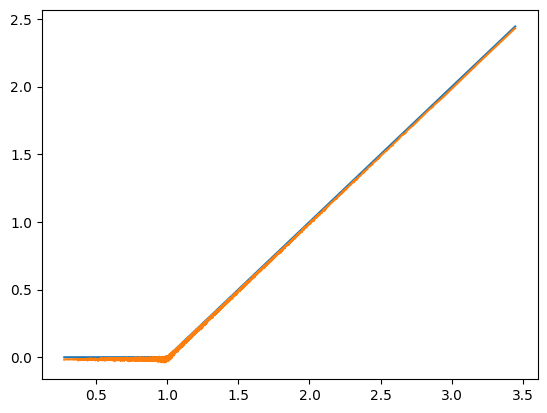

In [40]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(
    np.sort(paths[:, -1]),
    pnl_hedge[np.argsort(paths[:, -1])] + european_call.price().T.squeeze(1),
)
plt.show()

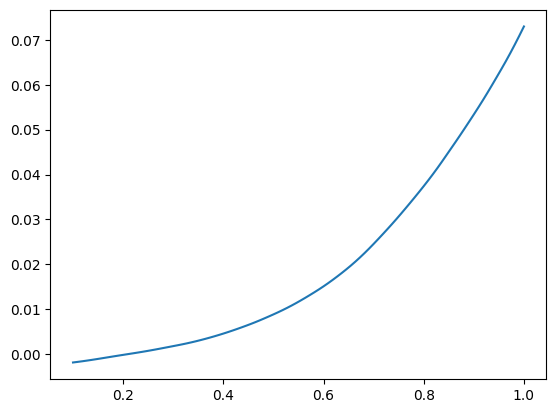

In [41]:
hedge_paths, opt_paths = [], []
vols = np.linspace(0.10, 1.0, 100)
for vol in vols:
    paths = pricer.get_paths(
        spot=[1.0],
        time_till_maturity=TILL_MATURITY,
        risk_free_rate_fn=curve.rate,
        dividends_fn=lambda t: 0.0,
        var_covar_fn=lambda t: np.array([vol**2] * len(t)),
        n_paths=N_PATHS,
    ).squeeze(2)
    pnl_hedge, pnl_opt = simulate_pnl(paths, european_call)
    hedge_paths.append(pnl_hedge.mean())
    opt_paths.append(pnl_opt.mean())
plt.plot(vols, -np.array(hedge_paths))
plt.show()

### !!! Справедливая цена дериватива определяется стоимостью остаточного риска, который нельзя захеджировать. Хеджирующая стратегия получается путём $\mathbb{V^Q}[PnL_{derivative} - PnL_{strategy}(\theta)] \rightarrow \underset{\theta}{\min}$. Таким образом, справедливая цена получается как матожидание (константа) величины $\mathbb{E^Q}[PnL_{derivative} - PnL_{strategy}(\^{\theta})]$, где PnL стратегии получен в следствие минимизации стандартного отклонения.

### Наличие транзакционных издержек делает зависимым справедливую стоимость дериватива (как остаточную стоимость от хеджирования) от траектории хеджирования.